In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fs
import requests
from xml.etree import ElementTree as ET
import xml
from uszipcode import SearchEngine
import folium

In [2]:
# let's first load our data starting with 2021 data
df = pd.read_excel("ghgp_data_files/ghgp_data_2021.xlsx", 
                     sheet_name='Direct Emitters', skiprows=3)


# now we want to also only select the columns that we are interested in
keep_cols = ['Facility Id', 'Facility Name' , 'City', 'State', 'Zip Code', 
             'County', 'Latitude', 'Longitude', 'Primary NAICS Code', 
             'Industry Type (subparts)', 'Industry Type (sectors)', 
             'Total reported direct emissions', 'CO2 emissions (non-biogenic) ', 
             'Methane (CH4) emissions ', 'Stationary Combustion', 
             'Electricity Generation', ]

# now let's filter our data
df = df[keep_cols]

# now we want to rename the following columns to names that we can easily refer to
new_cols = ['facility_id', 'facility_name', 'city', 'state', 'zipcode', 'county' ,
            'latitude', 'longitude', 'primary_naics_code', 'idustry_type_subparts', 'industry_type_sectors', 'total_reported_e', 'co2_e', 'methane_e', 'stationary_comb_e', 'electricty_gen_e']

# now we want to rename our columns to make more sense and be more accessible
df.columns = new_cols


print(df)

      facility_id                              facility_name  \
0         1004377             121 REGIONAL DISPOSAL FACILITY   
1         1010040                          15-18565/15-18662   
2         1000112                               23rd and 3rd   
3         1003742                       31st Street Landfill   
4         1003188                               3M BROWNWOOD   
...           ...                                        ...   
6476      1012921  Washington Court House Compressor Station   
6477      1006154                Waterloo Compressor Station   
6478      1003436                Westdale Compressor Station   
6479      1000912                                   Williams   
6480      1001640                      Wrenshall LNG Storage   

                        city state  zipcode             county   latitude  \
0                    MELISSA    TX    75454      COLLIN COUNTY  33.298570   
1                     Hazard    KY    40701       PERRY COUNTY  37.274127   


In [3]:
def plot_it(dataframe, filter_by, x_ax, y_ax):

    '''
    Purpose is to plot various emission types while also sorting values
    '''
    # filtering by input and also making sure values are in descending order
    df = dataframe.sort_values(by=filter_by, ascending=False)

    # now we want to  create a plot with the information that we have provided
    fig = plt.figure()

    # here we are setting our fig width and height
    fig.set_figheight(12)
    fig.set_figwidth(18)

    sns.barplot(data=df, x=x_ax, y=y_ax, ci=None)

    # no we are applying some edits to our figure
    plt.xticks(rotation=90)

    plt.show()



C:\Users\aange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd

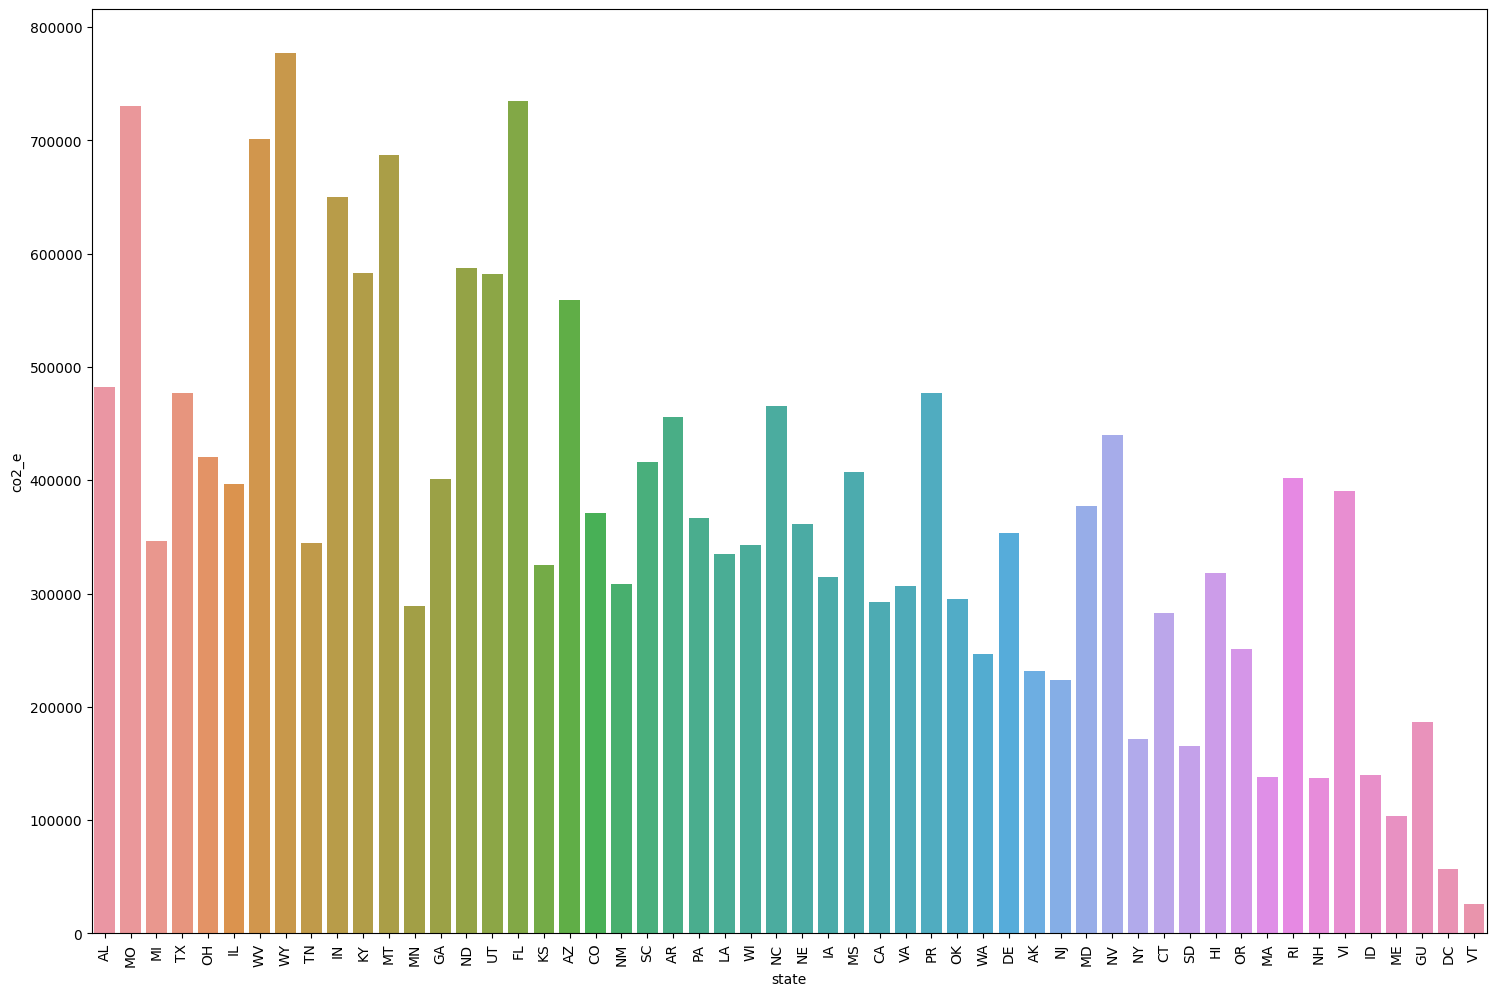

C:\Users\aange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\aange\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd

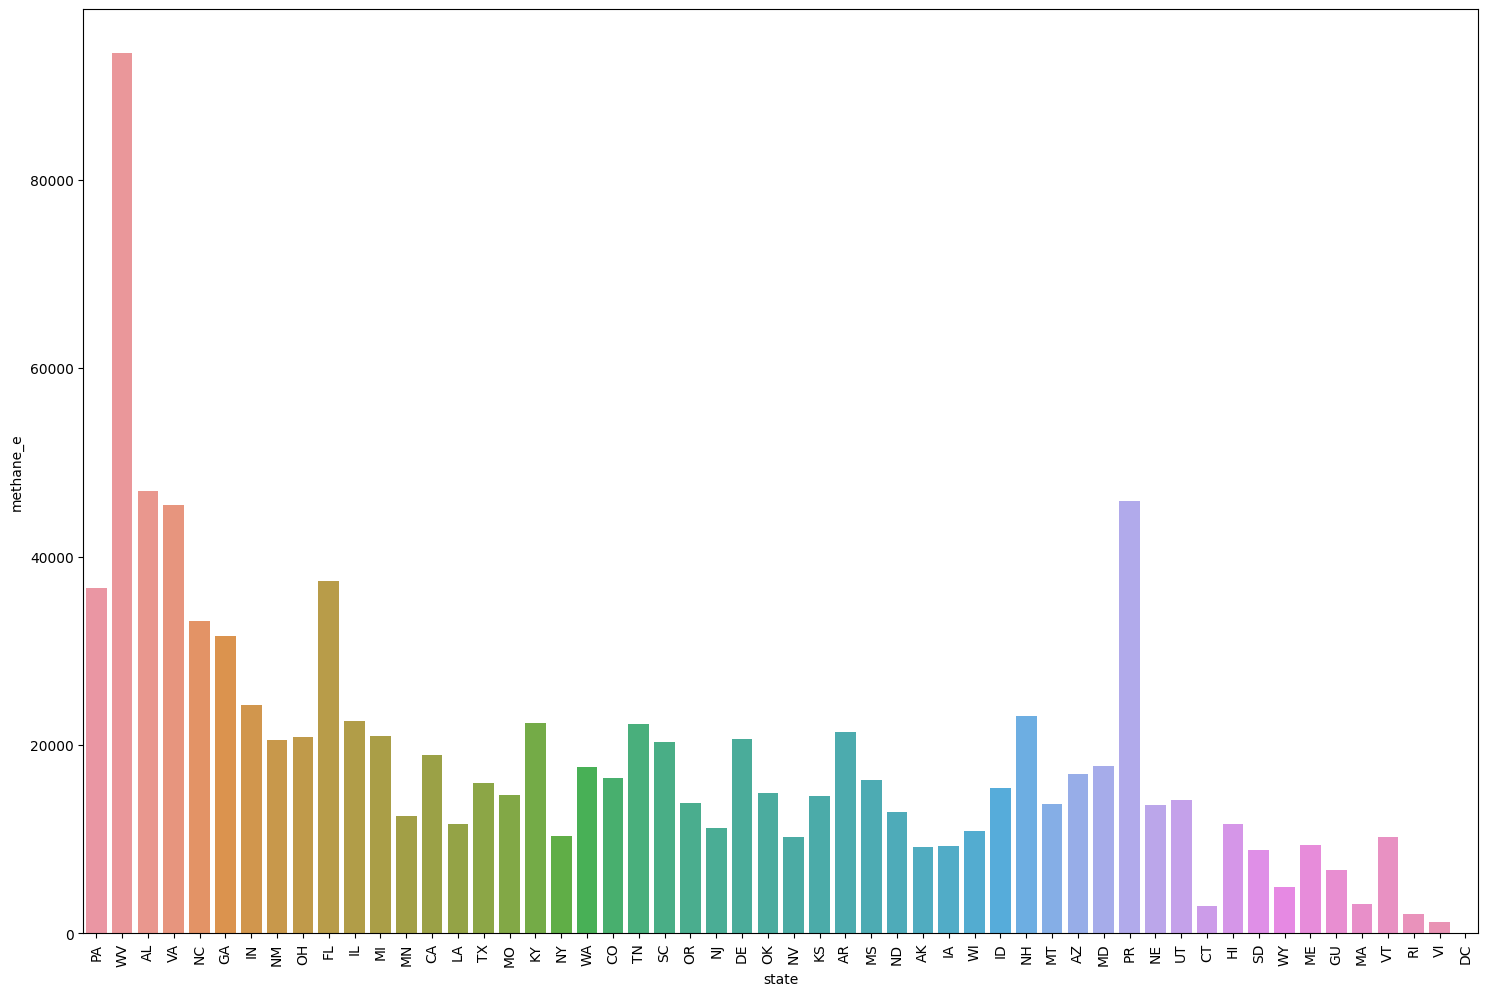

In [4]:
plot_it(dataframe=df, filter_by='co2_e', x_ax='state', y_ax='co2_e')
plot_it(dataframe=df, filter_by='methane_e', x_ax='state', y_ax='methane_e')

In [5]:
def meander_xml(ghgp_id, topic, year=2022):

    '''
    Given a ghgp_id, return the fuel type within the xml code.
    The purpose of this function is extract and process an XML file.

    Not entirely sure what an XML file is, or how it compares to a JSON file but it seems
    very low memory and has a tree structure.

    This is how facilities provide reports to the EPA emissions entity. 

    Please note that you need to:

    'pip install elementpath' and then import the module into your env

    to import: 
    'xml.etree.ElementTree as ET'
    '''

    try:

        # here, we will be adding the ghgp_id value to a url used to make GET request
        url = f'https://ghgdata.epa.gov/ghgp/service/xml/{year}?id={ghgp_id}&et=undefined'

        # making the url GET request for the xml file
        response = requests.get(url=url)
        webpage_content = response.text

        # modifying our url contnet because it containts code we do not need
        lines = webpage_content[38:-6].split('\n')
        modified_content = '\n'.join(lines[1:])

        # parse the XML
        root = ET.fromstring(modified_content)

        # now we want to create an ifelse statement that will grab specific data
        # user needs

        if topic == 'Fuel Type' or topic == 'fuel type':

            # creating a list to return the found elements to
            fuel_types = []

            # extract the fuel type element
            for fuel_type in root.findall(".//FuelType"):

                # return the fuel_type value
                fuel_types.append(fuel_type.text)
            
            # removing redundancies
            fuel_types = list(set(fuel_types))

            # concatenating our list to output a long string
            fuel_typez = ", ".join([str(item) for item in fuel_types])

            return fuel_typez
    

        elif topic == 'Unit Type' or topic == 'unit type':
    
            # creating a list to return the found elements to
            unit_types = []

            # extract the unit type value
            for unit_type in root.findall('.//UnitType'):

                # return the unit_type value
                unit_types.append(unit_type.text)
            
            # removing redundancies
            unit_types = list(set(unit_types))

            # concatenating our list to output a long string
            unit_typez = ", ".join([str(item) for item in unit_types])

            return unit_typez
    

        elif topic =='Parent Company' or topic == 'parent company': 
        
            # creating a list to return the found elements to
            parent_cos = []
            
            # else, extract parent company name 
            for parent_co in root.findall('.//ParentCompanyLegalName'):

                # return the parent company name
                parent_cos.append(parent_co.text)
            
            # removing redundancies
            parent_cos = list(set(parent_cos))

            # concatenating our list to output a long string
            parent_coz = ", ".join([str(item) for item in parent_cos])

            return parent_coz
    

        else: 

            # means none of the 3 topics were given 
            print('Error: please insert a valid topic to receive a valid value!')


    except xml.etree.ElementTree.ParseError:
        # xml file is not properly formatted, so skip this iteration
        "sorry, bud!"
        pass
    

In [6]:
# trying out the function that we have created below
test = meander_xml(ghgp_id='1010040', topic='parent company', year=2018)

print(test)


CAMBRIAN COAL LLC


Okay, we can prove now that our meander xml function works
let's move on up to another function we have created
Known as the insert location function 
Something to note is that the insert location function uses the get county from zip

We need to import uszipcode and search engine!

In [7]:
def zip_to_county(zipcode):

    '''
    The purpose of this file is to return a coutny when given a zipcode value. 

    Specifically, we will be working with an EPA Emissions data file for 2021 that provides us with emissions data for the united states. 

    The main issue is that the data is incomplete in terms of county values. 
    Thus, we need to go into each worksheet and fill in the county values by using the reported zipcodes that are included...
    '''

    search = SearchEngine()
    result = search.by_zipcode(zipcode)
    
    if result:
        return result.county
    else:
        return None

In [8]:
# let's test one out and see what happens
sdale = zip_to_county(72764)
hp = zip_to_county(60637)

print(sdale)
print(hp)

# it works, moving forward!



Washington County
Cook County


In [9]:
def insert_location(dataframe):

    '''
    The purpose of this function is to iterate through each row of a dataframe and add a county value if there is not one already there
    '''

    for index, row in dataframe.iterrows():

        # check if County column is empty 
        county_value = row['county']

        if pd.isna(county_value) or county_value == '':

            # 
            dataframe.at[index, 'county'] = zip_to_county(row['zipcode'])

        else:

            # if not empty, then just leave alone
            continue

    # now let's add a new column to our dataframe that adds the County and the State
    dataframe['location'] = dataframe['county'] + ', ' + dataframe['state']

    return dataframe

In [10]:
# section where we will be testing our insert location function 
test_df = insert_location(dataframe=df)

print(test_df)

# okay this works, now moving on!

      facility_id                              facility_name  \
0         1004377             121 REGIONAL DISPOSAL FACILITY   
1         1010040                          15-18565/15-18662   
2         1000112                               23rd and 3rd   
3         1003742                       31st Street Landfill   
4         1003188                               3M BROWNWOOD   
...           ...                                        ...   
6476      1012921  Washington Court House Compressor Station   
6477      1006154                Waterloo Compressor Station   
6478      1003436                Westdale Compressor Station   
6479      1000912                                   Williams   
6480      1001640                      Wrenshall LNG Storage   

                        city state  zipcode             county   latitude  \
0                    MELISSA    TX    75454      COLLIN COUNTY  33.298570   
1                     Hazard    KY    40701       PERRY COUNTY  37.274127   


Okay now we want to make sure that our clean county value function is working 
properly

In [11]:
def clean_county_val(dataframe):
    '''
    The purpose of this function is to iterate through each row in our dfs and remove the word County from the County column value
    '''

    # these are the words that we want to remove
    words_to_remove = ['County', 'county', 'COUNTY', 'Parish', 'parish', 
                       'PARISH']

    # regular expression pattern to match any of the words 
    pattern = "|".join(words_to_remove)

    # removing the words from the column value 
    dataframe['county'] = dataframe['county'].str.replace(pattern, '', regex=True)

    # making all County names uppercase
    dataframe['county'] = dataframe['county'].str.upper()

    return dataframe



In [12]:
# now we are testing to see if our clean county val function works
test_df = clean_county_val(dataframe=df)

print(test_df)

      facility_id                              facility_name  \
0         1004377             121 REGIONAL DISPOSAL FACILITY   
1         1010040                          15-18565/15-18662   
2         1000112                               23rd and 3rd   
3         1003742                       31st Street Landfill   
4         1003188                               3M BROWNWOOD   
...           ...                                        ...   
6476      1012921  Washington Court House Compressor Station   
6477      1006154                Waterloo Compressor Station   
6478      1003436                Westdale Compressor Station   
6479      1000912                                   Williams   
6480      1001640                      Wrenshall LNG Storage   

                        city state  zipcode       county   latitude  \
0                    MELISSA    TX    75454      COLLIN   33.298570   
1                     Hazard    KY    40701       PERRY   37.274127   
2                 

now we want to put everything together and see how out function does in terms of 
processing the data we have provided

In [13]:
# creating a map it function that will be needed, this is the last piece of 
# our master fuction 
'''
The purpose of this function is to create a map with the long, and lat values in dfs

'''

def format_number(x):

    """Format the number with commas and no decimal points."""
    return "{:,.0f}".format(x)


def map_it(dataframe, save_path, color='red', size=(10,10), tiles="OpenStreetMap"):

    # here we want to create a dictionary of type of facilities to color our markers
    facility_color = {
        'Power Plants': 'green'
    }

    # let's convert some of the column values into values with commas and no decimals
    dataframe["Total Reported Emissions"] = dataframe["Total Reported Emissions"].apply(format_number)
    dataframe["CO2 emissions (non-biogenic) "] = dataframe["CO2 emissions (non-biogenic) "].apply(format_number)


    # create a map centered on the USA
    map = folium.Map(location = [39.8283, -98.5795], # center of map 
                     zoom_start=  4, # where you want to start in zoom
                     tiles = tiles) # map type
    

    # iterating through our df to add markers
    for index, row in dataframe.iterrows():

        #Setup the content of the popup
        iframe = folium.IFrame(f'Facility Name: {str(row["FACILITY NAME"])} <br> Industry Type: {str(row["Industry Type (sectors)"])} <br> Total Reported Emissions: {str(row["Total Reported Emissions"])} <br> CO2 Emissions: {str(row["CO2 emissions (non-biogenic) "])} <br> Parent Company: {str(row["Parent Company"])} <br> Unit Type: {str(row["Unit Type"])} <br> Fuel Type: {str(row["Fuel Type"])}')
    
        #Initialise the popup using the iframe
        popup = folium.Popup(iframe, min_width=300, max_width=300)
    
        try:
            icon_color = facility_color[row['Industry Type (sectors)']]
        
        except:
            #Catch nans
            icon_color = 'gray'

        folium.Marker(
            location = [row['LATITUDE'], row['LONGITUDE']],
            icon = folium.Icon(
            color = icon_color,
            icon = '',
            shadow = None,
            size = size,
            ),
            popup = popup
        ).add_to(map)


    # now we are saving our map given the save path
    map.save(save_path)


In [14]:
# code needed to concatenate counties
'''
The purpose of this function is to parse out the first and second index values of a
county, state array.

Moreover, this function will concatenate the values and create a new column:

for instance, say you have ['Benton', 'AR']...

function will concatenate and create a new column--> 'Benton, AR'
'''

def county_concat(county_list): 

    # let's create an empty list to store our concatenated counties list
    empty_list = []

    for county in county_list:

        # we want to concatenate
        concat = county[0].upper() + ", " + county[1].upper()
        empty_list.append(concat)

    # now we just return the newly list that we created
    return empty_list

In [15]:
# code needed to filter our df
'''
The purpose of this code is to select a minimum emissions standard and remove any emitters that do not meet this threshold
'''

def filter_df(dataframe, minimum_e, counties=[]):

    # filters out any rows with values that do not meed the minimum threshold
    try:
        # Try accessing column with the first name
        dataframe = dataframe[dataframe['GHG QUANTITY (METRIC TONS CO2e)'] >= minimum_e]

    except KeyError:
        
        try:
            # If the first column name is not found, try the second name
            dataframe = dataframe[dataframe['Total Reported Emissions'] >= minimum_e]
        
        except KeyError:
            # If neither column name is found, handle the error or raise an exception
            print("Both column names not found!")    

    # filters out by counties you are interested in looking at
    # for it to work, you need to provide a counties list, else it ignores it
    if len(counties) > 0: 

        # then run process of filtering our by list of counties
        dataframe = dataframe[dataframe['location'].isin(counties)]

        return dataframe

    else: 

        # in essence, just continue
        return dataframe

In [16]:
def process_it(data, minimum_e, save_excel, save_map, river_c=[]):

    # now we want to also only select the columns that we are interested in
    keep_cols = ['Facility Id', 'Facility Name' , 'City', 'State', 'Zip Code', 
                'County', 'Latitude', 'Longitude', 'Primary NAICS Code', 
                'Industry Type (subparts)', 'Industry Type (sectors)', 
                'Total reported direct emissions', 'CO2 emissions (non-biogenic) ', 
                'Methane (CH4) emissions ', 'Stationary Combustion', 
                'Electricity Generation', ]

    # now let's filter our data
    data = data[keep_cols]

    # now we want to rename the following columns to names that we can easily refer # to
    new_cols = ['facility_id', 'facility_name', 'city', 'state', 'zipcode', 'county' ,
                'latitude', 'longitude', 'primary_naics_code', 'idustry_type_subparts', 'industry_type_sectors', 'total_reported_e', 'co2_e', 'methane_e', 'stationary_comb_e', 'electricty_gen_e']

    # now we want to rename our columns to make more sense and be more accessible
    data.columns = new_cols  

    # HERE WE ARE NOW MODIFYING PROCESSING OUR DATAFRAME
    # setting up the counties we want to focus on
    river_counties = county_concat(river_c)

    # first we will clean the county values
    df = clean_county_val(data)

    # insert locations column
    df = insert_location(df)

    # if there are counties given then process, else continue without processing any
    if len(river_c) > 0:
        # filter our df
        df = filter_df(df, minimum_e, counties=river_counties)

    else: 
        df = filter_df(df, minimum_e)

    # adding the needed empty columns in our dataframe
    # these columns will be populated with data from meander_xml function
    df['Unit Type'] = ''
    df['Parent Company'] = ''
    df['Fuel Type'] = ''   


    for index, row in df.iterrows():

        '''
        purpose is to go through, grab the 3 values and add them to the dataframe
        '''

        # defining our ghgp_id from the row we just grabbed
        ghgp = row['facility_id']
        print(ghgp)

        # now we will be grabbing and adding the 3 values to our datframe
        # adding a unit type value
        df.loc[index, 'Unit Type'] = meander_xml(ghgp_id=ghgp, topic='unit type')

        # adding a parent company value
        df.loc[index, 'Parent Company'] = meander_xml(ghgp_id=ghgp, topic='parent company')

        # adding a fuel type value
        df.loc[index, 'Fuel Type'] = meander_xml(ghgp_id=ghgp, topic='fuel type')


    # output as an excel file
    df.to_excel(save_excel, index=False)

    # now we want to map our data
    if len(save_map) > 0: 
        '''
        if there is a value in save_map then we should start process of passing
        this function 
        '''
        map_it(df, save_map)
        print('succesfully created map :3')
    
    else: 
        print('no map created :/')

Yay! now we can test our main function and see what happens. 

Let's do it!

In [ ]:
# let's first load our data starting with 2021 data
df = pd.read_excel("ghgp_data_files/ghgp_data_2021.xlsx", 
                     sheet_name='Direct Emitters', skiprows=3)

# direct emitters needed vars to process data and save it
excel_path_de = "ghgp_processed/data_files/general_dems_2021_data.xlsx"
map_path_de = "ghgp_processed/maps/general_dems_2021_data.html"

# now we are processing our data for mississippi river, direct emitters
process_it(data=df, minimum_e=1_000_000, river_c=[], 
          save_excel=excel_path_de, save_map=map_path_de)